In [1]:
import numpy as np
import matplotlib.pyplot as plt

from slider import Preprocessing, Settings, Visualization
from slider import ImageAnalysis, ParticleAnalysis

from sklearn.neighbors import KDTree

In [2]:
photoelasticImageData, whiteLightImageData, forceData, trackingData, metadata = Preprocessing.loadSliderData(loadCachedData=True, saveCachedData=True)

Reading tracking data from cache: Cache/Tracking/shape0_01.pickle


In [32]:
image = ImageAnalysis.checkImageType(photoelasticImageData[0][0])
imageSize = np.array(np.shape(image)[:2])

#center = imageSize/2
center = [800, 200]

testInitialData = trackingData[0][0]

kdTree = KDTree(testInitialData[:,:2])

dist, ind = kdTree.query([center], k=6)

testInitialData = testInitialData[ind[0]]
testInitialPositions = testInitialData[:,:2]

testFinalData = trackingData[0][500]

kdTree = KDTree(testFinalData[:,:2])

dist, ind = kdTree.query([center], k=6)

testFinalData = testFinalData[ind[0]]
testFinalPositions = testFinalData[:,:2]

print(testInitialPositions)

[[793.022575 189.995998]
 [811.007442 221.998923]
 [770.007477 222.027227]
 [836.990795 192.016218]
 [813.017824 158.990948]
 [758.011289 181.992666]]


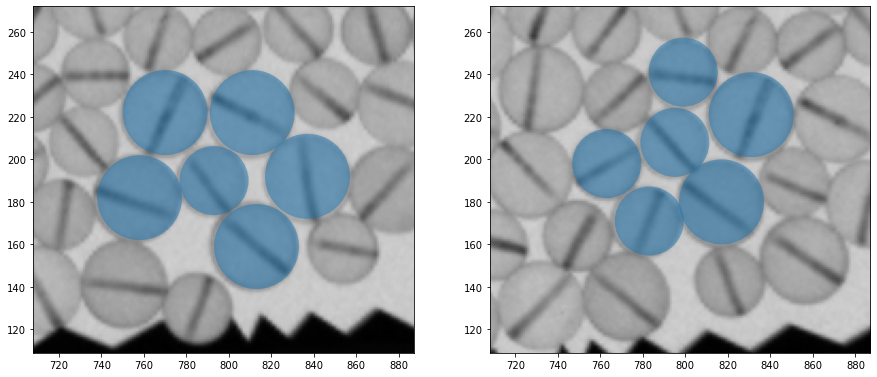

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))

Visualization.visualizeTrackedParticles(testInitialData, whiteLightImageData[0][0], ax=ax[0])
for i in range(2):
    ax[i].set_xlim([min(testInitialPositions[:,0])-50, max(testInitialPositions[:,0])+50])
    ax[i].set_ylim([min(testInitialPositions[:,1])-50, max(testInitialPositions[:,1])+50])

Visualization.visualizeTrackedParticles(testFinalData, whiteLightImageData[0][500], color='red', ax=ax[1])

plt.show()

In [9]:
print(ParticleAnalysis.DSquaredMin(testInitialPositions, testFinalPositions))

648682.1074116039


In [11]:
from numpy.linalg import inv

def get_d2min(bonds0, bonds):
    """ Calculate the d2min of two 2d arrays
    Args:
        bonds0: N*d double array, reference bonds vector
        bonds:  N*d double array, current bonds vector
    Returns:
        (d2min, J, eta_s), eta_s is the von-Mises strain
    Notes:
        V = bonds0.T * bonds0, 3*N N*3 = 3*3
        W = bonds0.T * bonds 
        J = V^-1 * W
        d2min = |bonds0 - J*bonds|
        eta = 0.5*(J*J.T-I), Lagrangian strain matrix
        eta_m = 1.0/3.0*trace(eta), dilational component
        eta_s = \sqrt{0.5*trace(eta-eta_m*I)}, von-Mises strain
    Examples:
        b0 = [[1,0], [0,1]]
        b = [[1,0.1], [0.1,1]]
        d2min, J, eta_s = get_d2min(b0,b)
        
    Reference:
        Falk, M. L., & Langer, J. S. (1998)
        http://li.mit.edu/Archive/Graphics/A/
    """
    # convert to numpy matrix
    b0 = np.mat(bonds0)
    b = np.mat(bonds)

    # get the dimension of bonds
    dimension = b0.shape[1]

    # get V and W
    V = b0.transpose() * b0
    W = b0.transpose() * b

    # calculate J
    #print("V:",V)
    #print("b0:",b0)
    #print("b:",b)
    J = inv(V) * W

    # non-affine part
    non_affine = b0*J - b

    # d2min
    d2min = np.sum(np.square(non_affine))

    # get Lagrangian strain matrix
    eta = 0.5 * (J * J.transpose() - np.eye(dimension))

    # get von-Mises strain
    if dimension == 0:
        print("dimension:",dimension)
        print("b0:",b0)
        print("b:",b)
        sys.exit(1)
    eta_m = 1.0/np.double(dimension) * np.trace(eta)
    tmp = eta - eta_m * np.eye(dimension)
    eta_s = np.sqrt(0.5*np.trace(tmp*tmp))
    #print(J)
    #print(d2min)
    #print(eta_s)
    #sys.exit()
    return (d2min, J, eta_s)

In [12]:
print(get_d2min(testInitialPositions, testFinalPositions))
print(ParticleAnalysis.DSquaredMin(testInitialPositions, testFinalPositions))

(29.136179236073065, matrix([[0.99329227, 0.01937654],
        [0.00662001, 0.99158141]]), 0.01292813865134862)
648682.1074116039
